In [1]:
import pandas as pd
import numpy as np
import fileinput
from IPython.display import display
import ipywidgets as widgets
import PyPDF2
import io
import re

# Read File

In [33]:
extracted_text = ""

def handle_pdf_upload(change):
    import fitz  # PyMuPDF
    
    print ('** pdf file detected!')
    global extracted_text
    
    uploaded_file = list(change.new.values())[0]
    content = uploaded_file['content']
    
    # secured pdf
    doc = fitz.open(stream=io.BytesIO(content), filetype='pdf')
    text = ""
    for page in doc:
        text += page.get_text()
    
    # regular pdf
#     reader = PyPDF2.PdfFileReader(io.BytesIO(content))
#     text = ''
#     for page in reader.pages:
#         text += page.extract_text()

    # Further processing with the extracted text
    extracted_text = text
    print(text)
    print('PDF submitted successfully!')

# file_selector = widgets.FileUpload(accept='.pdf', multiple = False)
# file_selector.observe(handle_pdf_upload, names='value')

def handle_csv_xlsx_upload(change):
    print('** csv xlsx file detected!')
    global extracted_text
#     print (change)

    uploaded_file = list(change.new.values())[0]
    content = uploaded_file['content']
    file_type = uploaded_file['metadata']['name'].split('.')[-1]  # Extract file type from name

    text = ""
    if file_type == 'xlsx':
        data = pd.read_excel(io.BytesIO(content), sheet_name=None)
        for sheet,df in data.items():
            print (sheet)
            
        # Only keep sheets that match the format "CONDENSED CONSOLIDATED STATEM_#"
        data = {sheet: df for sheet, df in data.items() if re.match(r'CONDENSED CONSOLIDATED*', sheet)}
        for sheet, df in data.items():
            text += f"\n\n--- {sheet} ---\n\n"
            text += df.to_string(index = False)
    elif file_type == 'csv':
        data = pd.read_csv(io.StringIO(content.decode('utf-8')))  # Decoding needed for CSV file
        text = data.to_string(index = False)

    # Further processing with the extracted text
    extracted_text = text
    print(text)
    print(f'{file_type.upper()} file submitted successfully!')
    
def handle_file_upload(change):
    print('Start')
#     global extracted_text
#     print (change)

    uploaded_file = list(change.new.values())[0]
    content = uploaded_file['content']
    file_type = uploaded_file['metadata']['name'].split('.')[-1]  # Extract file type from name

    text = ""
    if file_type == 'pdf':
        handle_pdf_upload(change)
    else:
        handle_csv_xlsx_upload(change)

file_selector = widgets.FileUpload(accept='.xlsx, .csv, .pdf', multiple = False)
file_selector.observe(handle_file_upload, names='value')

display(file_selector)

FileUpload(value={}, accept='.xlsx, .csv, .pdf', description='Upload')

Start
** pdf file detected!
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
WASHINGTON, DC 20549
FORM 10-Q
(Mark One)
☒
QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the quarterly period ended March 31, 2023
OR
£
TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934
For the transition period from _________ to _________
Commission File Number: 001-39540
________________________________________________
Palantir Technologies Inc.
(Exact Name of Registrant as Specified in its Charter)
________________________________________________
Delaware
68-0551851
(State or other jurisdiction of
incorporation or organization)
(I.R.S. Employer
Identification No.)
1200 17th Street, Floor 15
Denver, Colorado
80202
(Address of principal executive offices)
(Zip Code)
Registrant’s telephone number, including area code: (720) 358-3679
Securities registered pursuant to Section 12(b) of the Act:
Title of each class
Trading
Symbol

In [34]:
extracted_text

'UNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWASHINGTON, DC 20549\nFORM 10-Q\n(Mark One)\n☒\nQUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the quarterly period ended March 31, 2023\nOR\n£\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from _________ to _________\nCommission File Number: 001-39540\n________________________________________________\nPalantir Technologies Inc.\n(Exact Name of Registrant as Specified in its Charter)\n________________________________________________\nDelaware\n68-0551851\n(State or other jurisdiction of\nincorporation or organization)\n(I.R.S. Employer\nIdentification No.)\n1200 17th Street, Floor 15\nDenver, Colorado\n80202\n(Address of principal executive offices)\n(Zip Code)\nRegistrant’s telephone number, including area code: (720) 358-3679\nSecurities registered pursuant to Section 12(b) of the Act:\nTitle of each class\nTrading\nS

# LLM usage

In [35]:
import openai

# Load API key from a separate file
with open("openai.txt", "r") as file:
    api_key = file.read().strip()

openai.api_key = api_key

In [77]:
import textwrap

generated_text = ""

def generate_text_with_openai(extracted_text):
    chunk_size=12000 # adjust based on the used model
    chunks = textwrap.wrap(extracted_text, chunk_size)

    generated_texts = []

    for chunk in chunks:

#         # Set the prompt for the OpenAI model
#         prompt = f"You are a financial analysis with 20 years of experience. You are set to analyze, \
#                     summarize, identify and highlight information from conference call transcript. \
#                     Here is the transscript: {extracted_text}"

        # Set the desired number of tokens for the generated text
        max_tokens = 12000  # Adjust the value as per your requirement

        # Generate text using the OpenAI model
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo-16k", # change model here depends on documentation
#             prompt=prompt,
            messages=[
                # If use for summary conference call transcript
#                 {
#                     "role": "system",
#                     "content": "You are a financial analysis with 20 years of experience. \
#                                 User will give you transcript, you will analyze, summarize, identify and highlight \
#                                 information from conference call transcript. \
#                                 You will firstly assess if this call is positive, neutral or negative for the company.\
#                                 The other information is in bullet point"
#                 },
                
#               If use for financial reading
                {
                    "role": "system",
                    "content": "You are a financial analysis with 20 years of experience. \
                                User will give you financial reports, you will analyze, summarize, identify and highlight \
                                information from that given report. Only extract metrics, no need to explain. \
                                For the output, information is in bullet point. Sample output format is strictly like this:\
                                - Cash and cash equivalents increased|decreased|remained stable $123 $234.\
                                Beside of these mandatory metric to look for, include all other metrics if you find it: \
                                Cost of revenue, Revenue, Sales and marketing expenses, \
                                Total current assets, Total current liabilities, Total equity, Total assets"
                },
                {
                    "role": "user",
                    "content": chunk
                }
            ],
            max_tokens=max_tokens,
            n=1,
            stop=None,
            temperature=0.7
        )

        # Extract the generated text from the OpenAI response
        generated_text = response.choices[0].message.content.strip()
        
        generated_texts.append(generated_text)
        
    # Combine all the generated text chunks into one string
    full_generated_text = " ".join(generated_texts)

    return full_generated_text

generated_text = generate_text_with_openai(extracted_text)

In [78]:
generated_text

'- Cash and cash equivalents decreased $1,333,802 from $2,598,540 to $1,264,738\n- Marketable securities increased $1,604,662 from $35,135 to $1,639,797\n- Revenue increased $78,829 from $446,357 to $525,186\n- Cost of revenue increased $13,242 from $94,403 to $107,645\n- Sales and marketing expenses increased $26,608 from $160,485 to $187,093\n- Total current assets increased $214,570 from $3,041,577 to $3,256,147\n- Total current liabilities increased $13,472 from $587,941 to $601,413\n- Total stockholders\' equity increased $158,407 from $2,565,326 to $2,723,733 - Cash and cash equivalents decreased from $2,269,411 to $1,264,738\n- Accounts receivable decreased from $258.3 million to $254.0 million\n- Deferred revenue increased from $339.2 million to $427.9 million\n- Revenue recognized during the three months ended March 31, 2023, was $192.4 million\n- Revenue recognized during the three months ended March 31, 2022, was $187.0 million\n- Customer K represented 10% of total revenue 

# Convert to DF

In [238]:
# Avoid rerun model, costing money:
# money losing company example
generated_text = "- Cash and cash equivalents increased from $204,178 to $256,363.\n- Available-for-sale securities increased from $1,445,759 to $1,459,229.\n- Accounts receivable, net increased from $148,544 to $179,749.\n- Contract assets decreased from $8,292 to $8,023.\n- Prepaid expenses and other current assets decreased from $70,556 to $40,531.\n- Total current assets increased from $1,887,884 to $1,954,400.\n- Property and equipment, net increased from $286,600 to $298,188.\n- Goodwill remained stable at $148,047.\n- Acquired intangible assets, net decreased from $32,483 to $27,596.\n- Operating lease right-of-use assets decreased from $132,360 to $130,908.\n- Deferred contract acquisition costs, noncurrent increased from $93,145 to $98,427.\n- Restricted cash increased from $471 to $1,564.\n- Other noncurrent assets increased from $6,918 to $8,434.\n- Total assets increased from $2,587,908 to $2,667,564.\n- Accounts payable increased from $35,607 to $54,563.\n- Accrued expenses and other current liabilities increased from $66,425 to $69,374.\n- Accrued compensation increased from $42,014 to $45,669.\n- Operating lease liabilities increased from $33,275 to $34,796.\n- Deferred revenue increased from $218,647 to $238,795.\n- Total current liabilities increased from $397,870 to $444,505.\n- Convertible senior notes, net increased from $1,436,192 to $1,437,355.\n- Operating lease liabilities, noncurrent increased from $107,624 to $108,804.\n- Deferred revenue, noncurrent increased from $11,732 to $13,465.\n- Other noncurrent liabilities increased from $10,526 to $10,849.\n- Total liabilities increased from $1,963,944 to $2,014,978.\n- Additional paid-in capital increased from $1,475,423 to $1,536,367.\n- Accumulated deficit increased from -$839,891 to -$877,973.\n- Accumulated other comprehensive loss decreased from -$11,896 to -$6,138.\n- Total stockholders' equity increased from $623,964 to $652,586.\n- Common stock, value, issued increased from 286 to 289 shares for Class A common stock.\n- Common stock, value, issued decreased from 42 to 41 shares for Class B common stock.\n- Revenue increased from $212,167 to $290,175.\n- Cost of revenue increased from $47,051 to $70,432.\n- Gross profit increased from $165,116 to $219,743.\n- Sales and marketing expenses increased from $100,057 to $137,001.\n- Research and development expenses increased from $67,054 to $81,539.\n- General and administrative expenses increased from $38,029 to $48,475.\n- Loss from operations decreased from -$40,024 to -$47,272.\n- Interest income increased from $1,061 to $13,487.\n- Interest expense decreased from -$1,557 to -$2,126.\n- Other income (expense), net decreased from -$487 to -$857.\n- Total non-operating income (expense), net increased from -$983 to $10,504.\n- Loss before income taxes decreased from -$41,007 to -$36,768.\n- Provision for income taxes increased from $374 to $1,314.\n- Net loss decreased from -$41,381 to -$38,082.\n- Net loss per share attributable to common stockholders, basic remained stable at -$0.12.\n- Net loss per share attributable to common stockholders, diluted remained stable at -$0.12.\n- Weighted-average shares used in computing net loss per share attributable to common stockholders, basic increased from 323,334 to 330,389.\n- Weighted-average shares used in computing net loss per share attributable to common stockholders, diluted increased from 323,334 to 330,389.\n- Other comprehensive income (loss) increased from -$10,100 to $5,758.\n- Comprehensive loss decreased from -$51,481 to -$32,324. - Issuance of common stock in connection with acquisition: 19,000 shares issued\n- Issuance of restricted stock in connection with acquisition: 52,000 shares issued\n- Issuance of common stock upon exercise of stock options: 65,000 shares issued\n- Vesting of shares issued upon early exercise of stock options: 23,000 shares vested\n- Issuance of common stock related to settlement of restricted stock units (RSUs): 410,000 shares issued\n- Tax withholding on RSU settlement: 6,000 shares withheld\n- Conversion of Class B to Class A common stock: 1,861,000 shares converted\n- Settlement of common stock in connection with convertible senior notes: 299,000 shares settled\n- Stock-based compensation: $35,181\n- Net loss: $41,381\n- Other comprehensive income (loss): -$10,100\n- Ending balance of common stock at Mar. 31, 2022: 515,477 shares\n- Ending balance of additional paid-in capital at Mar. 31, 2022: $1,215,790\n- Ending balance of retained earnings at Mar. 31, 2022: -$687,891\n- Ending balance of accumulated other comprehensive loss at Mar. 31, 2022: -$12,745\n- Beginning balance of common stock at Dec. 31, 2022: 623,964 shares\n- Beginning balance of additional paid-in capital at Dec. 31, 2022: $1,475,423\n- Beginning balance of retained earnings at Dec. 31, 2022: -$839,891\n- Beginning balance of accumulated other comprehensive loss at Dec. 31, 2022: -$11,896\n- Increase in stockholders' equity from issuance of common stock upon exercise of stock options: 806,000 shares issued - Issuance of common stock upon exercise of stock options: 3305 shares\n- Vesting of shares issued upon early exercise of stock options: 590 shares\n- Issuance of common stock related to settlement of restricted stock units (RSUs): 0 shares\n- Tax withholding on RSU settlement: -2058 shares\n- Conversion of Class B to Class A common stock: 2024000 shares\n- Stock-based compensation: $59,109\n- Net loss: -$38,082\n- Other comprehensive income (loss): $5,758\n- Ending balance of shares at Mar. 31, 2023: 289,372,222 shares\n- Ending balance at Mar. 31, 2023: $652,586\n- Net loss for the quarter: -$38,082\n- Depreciation and amortization expense: $31,509\n- Non-cash operating lease costs: $11,061\n- Amortization of deferred contract acquisition costs: $14,109\n- Stock-based compensation expense: $57,401\n- Amortization of debt issuance costs: $1,163\n- Net accretion of discounts and amortization of premiums on available-for-sale securities: -$8,228\n- Deferred income taxes: -$120\n- Provision for bad debt: $1,576\n- Changes in operating assets and liabilities, net of effect of acquisitions:\n  - Accounts receivable, net: -$32,781\n  - Contract assets: $269\n  - Deferred contract acquisition costs: -$19,391\n  - Prepaid expenses and other current assets: -$8,934\n  - Other noncurrent assets: -$811\n  - Accounts payable: $11,634\n  - Accrued expenses and other current liabilities: $650\n  - Operating lease liabilities: -$6,908\n  - Deferred revenue: $21,881\n  - Other noncurrent liabilities: $430\n- Net cash provided by (used in) operating activities: $36,414\n- Purchases of property and equipment: -$17,541\n- Capitalized internal-use software: -$4,970\n- Cash paid for acquisitions, net of cash acquired: $0\n- Purchases of available-for-sale securities: -$476,206\n- Sales of available-for-sale securities: $20,248\n- Maturities of available-for-sale securities: $493,988\n- Other investing activities: $48\n- Net cash provided by (used in) investing activities: $15,567\n- Repayments of convertible senior notes: $0\n- Proceeds from the exercise of stock options: $3,305\n- Proceeds from the early exercise of stock options: $0\n- Repurchases of unvested common stock: $0\n- Payment of tax withholding obligation on RSU settlement: -$2,058\n- Net cash provided by (used in) financing activities: $1,247\n- Net increase (decrease) in cash, cash equivalents, and restricted cash: $53,228\n- Cash, cash equivalents, and restricted cash, beginning of period: $215,204\n- Cash, cash equivalents, and restricted cash, end of period: $268,432 - Cash paid for interest: $1\n- Cash paid for income taxes, net of refunds: $1,260 (paid) and $874 (net of refunds)\n- Cash paid for operating lease liabilities: $7,265 (paid) and $8,291 (net)\n- Stock-based compensation capitalized for software development: $1,640 (capitalized)\n- Accounts payable and accrued expenses related to property and equipment additions: $13,276 (accounts payable) and $16,922 (accrued expenses)\n- Vesting of early exercised stock options: $590\n- Indemnity holdback consideration associated with business combinations: $0 (initial) and $1,275 (associated with business combinations)\n- Issuance of common stock related to an acquisition: $0 (initial) and $1,957 (related to an acquisition)\n- Operating lease right-of-use assets obtained in exchange for operating lease liabilities: $8,071 (obtained) and $15,966 (in exchange for operating lease liabilities)"

In [263]:
# profitable company example 
generated_text = "- Cash and cash equivalents decreased $1,333,802 from $2,598,540 to $1,264,738\n- Marketable securities increased $1,604,662 from $35,135 to $1,639,797\n- Revenue increased $78,829 from $446,357 to $525,186\n- Cost of revenue increased $13,242 from $94,403 to $107,645\n- Sales and marketing expenses increased $26,608 from $160,485 to $187,093\n- Total current assets increased $214,570 from $3,041,577 to $3,256,147\n- Total current liabilities increased $13,472 from $587,941 to $601,413\n- Total stockholders\' equity increased $158,407 from $2,565,326 to $2,723,733 - Cash and cash equivalents decreased from $2,269,411 to $1,264,738\n- Accounts receivable decreased from $258.3 million to $254.0 million\n- Deferred revenue increased from $339.2 million to $427.9 million\n- Revenue recognized during the three months ended March 31, 2023, was $192.4 million\n- Revenue recognized during the three months ended March 31, 2022, was $187.0 million\n- Customer K represented 10% of total revenue for the three months ended March 31, 2023\n- No customer represented 10% or more of total revenue for the three months ended March 31, 2022 - Cash and cash equivalents increased from $1,209,935 to $2,327,102\n- Restricted cash increased from $33,065 to $14,358\n- Marketable securities increased from $35,135 to $1,639,797\n- Total debt securities increased from $1,822,231 to $1,822,516\n- Property and equipment, net decreased from $69,170 to $63,115\n- Accrued liabilities increased from $172,715 to $174,525\n- The Company has an unsecured revolving credit facility with total revolving commitments of $500.0 million and a delayed draw term loan commitment of $450.0 million\n- The Company is committed to purchasing cloud hosting services with a minimum annual commitment of at least $1.49 billion over six contract years\n- The Company has satisfied $82.3 million of its $199.0 million commitment for contract year three ending September 30, 2023 - The Company is subject to various legal claims, disputes, and investigations\n- Securities class action complaints were filed against the Company and certain officers and directors\n- Stockholder derivative actions were filed against certain officers and directors asserting breach of fiduciary duty\n- The Company had irrevocable standby letters of credit and guarantees outstanding\n- The Company provides warranties for its software products and services and indemnifies customers against intellectual property claims\n- The Company\'s Class A, Class B, and Class F common stocks have different voting and conversion rights\n- No dividends have been declared as of March 31, 2023\n- Stock option activity: options exercised, canceled, and forfeited\n- RSU activity: RSUs granted, vested, converted to shares, and canceled\n- Total unrecognized stock-based compensation expense related to options and RSUs outstanding\n- Total stock-based compensation expense by category: cost of revenue, sales and marketing, research and development, general and administrative\n- Provision for income taxes recorded\n- Deferred tax assets and valuation allowances recorded - Net income increased from $16,802 to a loss of $101,379\n- Weighted-average shares used in computing net earnings per share increased from 2,036,307 to 2,217,439\n- Net earnings per share attributable to common stockholders increased from $0.01 to a loss of $0.05\n- Options issued and outstanding decreased from 342,475 to 162,521\n- RSUs outstanding decreased from 140,793 to 23,006\n- Warrants to purchase common stock remained stable at 13,042\n- Total revenue increased from $446,357 to $525,186\n- Revenue from the government segment increased from $241,790 to $289,070\n- Revenue from the commercial segment increased from $204,567 to $236,116\n- Total contribution increased from $252,418 to $279,160\n- Income (loss) from operations increased from $39,439 to $4,115\n- Research and development expenses increased from $61,696 to $70,176\n- General and administrative expenses increased from $80,838 to $90,155\n- Total stock-based compensation expense decreased from $149,323 to $114,714\n- Revenue from the United States increased from $272,913 to $336,845\n- Revenue from the United Kingdom remained stable at $49,579\n- Revenue from the rest of the world increased from $123,542 to $138,762\n- Gross carrying amount of intangible assets decreased from $40,436 to $38,943\n- Accumulated amortization of intangible assets increased from $4,897 to $5,813\n- Expected amortization expense for unamortized finite-lived intangible assets is as follows: $7,228 in the remainder of 2023, $7,844 in 2024, $4,597 in 2025, $4,597 in 2026, $4,250 in 2027, and $4,614 thereafter. - Revenue increased by 18% from Q1 2022 to Q1 2023\n- Income from operations was $4.1 million in Q1 2023, compared to losses from operations of $39.4 million in Q1 2022\n- Gross profit was $417.5 million in Q1 2023, with a gross margin of 80%\n- The company had 391 customers as of March 31, 2023, compared to 277 customers as of March 31, 2022\n- 55% of revenue came from government customers, while 45% came from commercial customers in Q1 2023\n- 64% of revenue came from customers in the United States, with the remaining 36% from non-U.S. customers in Q1 2023\n- Revenue from U.S. customers grew by 28% in the trailing twelve months ended March 31, 2023\n- The company is focused on expanding access to its platforms and partnering with a broad set of customers in both the commercial and government sectors\n- The company is monitoring macroeconomic trends, including the impact of the ongoing COVID-19 pandemic, on its business and financial results - Revenue is generated from the sale of subscriptions to access software in a hosted environment (Palantir Cloud) and software subscriptions in customers\' environments (On-Premises Software)\n- Palantir Cloud subscriptions are recognized over the contract term on a ratable basis\n- On-Premises Software sales include stand-ready O&M services and are recognized over the contractual term\n- Contribution margin for the three months ended March 31, 2023 was 53%\n- Gross margin, excluding stock-based compensation, for the three months ended March 31, 2023 was 81%\n- Adjusted income from operations for the three months ended March 31, 2023 was $125,114\n- Foreign currency exchange rates may adversely affect results of operations or financial position\n- Current macroeconomic conditions may adversely impact customers\' business, particularly early- and growth-stage customers\n- The ongoing Russia-Ukraine conflict is being closely monitored, but no material impact on business is expected\n- The COVID-19 pandemic has led to increased adoption of software solutions that can be implemented quickly - Revenue increased by $78.8 million, or 18%, for the three months ended March 31, 2023 compared to the same period in 2022.\n- Cost of revenue increased by $13.2 million, or 14%, for the three months ended March 31, 2023 compared to the same period in 2022.\n- Gross profit increased by $65.6 million, or 19%, for the three months ended March 31, 2023 compared to the same period in 2022.\n- Gross margin increased by 1% for the three months ended March 31, 2023 compared to the same period in 2022.\n- Sales and marketing expenses increased by $26.6 million, or 17%, for the three months ended March 31, 2023 compared to the same period in 2022.\n- Research and development expenses increased by $1.5 million, or 2%, for the three months ended March 31, 2023 compared to the same period in 2022.\n- General and administrative expenses decreased by $6.1 million, or 4%, for the three months ended March 31, 2023 compared to the same period in 2022. - Stock-based compensation expenses decreased by $34.6 million, or 23%\n- Interest income increased by $20.3 million\n- Interest expense increased by $0.7 million\n- Other income (expense), net changed by $57.0 million primarily due to a decrease in losses from publicly-traded equity securities\n- Provision for income taxes decreased by $342 thousand\n- Net cash provided by operating activities increased to $187.4 million\n- Net cash used in investing activities increased to $1.6 billion\n- Net cash provided by financing activities remained stable at $26.0 million\n- Cash and cash equivalents and short-term U.S. treasury securities totaled $2.9 billion as of March 31, 2023\n- Accumulated deficit balance was $5.8 billion\n- No outstanding debt balances as of March 31, 2023\n- Additional available and undrawn revolving and delayed draw term loan commitments of $950.0 million under the credit facility\n- No material change in contractual obligations and commitments\n- No material changes to critical accounting policies and estimates\n- No recent accounting pronouncements mentioned - We accept securities as compensation or invest in securities, which may contribute to additional volatility to our financial statements.\n- Our cash, cash equivalents, restricted cash, and available-for-sale debt securities consist of cash, certificates of deposit, money market funds, and U.S. treasury securities.\n- Our primary investment policy and strategies focus on the preservation of capital and supporting our liquidity requirements.\n- We make investments in early- and growth-stage companies.\n- Our contracts with customers are primarily denominated in U.S. dollars, with some in foreign currencies.\n- Our expenses are generally denominated in the currencies of the jurisdictions in which we conduct our operations.\n- Our results of operations and cash flows are subject to fluctuations due to changes in foreign currency exchange rates.\n- We have experienced fluctuations in net income (loss) due to transaction gains or losses related to remeasuring certain assets and liability balances denominated in foreign currencies.\n- Foreign currency transaction gains and losses have not been material to our financial statements, and we have not engaged in any foreign currency hedging transactions.\n- Inflation has not had a material effect on our business, results of operations, or financial condition.\n- Our costs becoming subject to significant inflationary pressures could harm our business, financial condition, or results of operations.\n- We have evaluated the effectiveness of our disclosure controls and procedures and concluded that they were effective at a reasonable assurance level.\n- There were no changes in our internal control over financial reporting during the period covered by this report that materially affected our internal control over financial reporting.\n- The effectiveness of our internal control over financial reporting is subject to inherent limitations.\n- We are subject to legal proceedings and claims arising in the ordinary course of business, but we do not anticipate material adverse effects on our business, results of operations, or financial condition.\n- Our business is subject to numerous risks and uncertainties, including those related to our history of losses, revenue growth, sales efforts, customer concentration, fluctuating results of operations, seasonality, platform complexity, technology development, personnel recruitment and retention, competition, brand and reputation, exclusive arrangements, culture management, joint ventures and partnerships, breach of systems, macroeconomic conditions, market development, strategic investments, artificial intelligence, computing infrastructure, intellectual property, errors and defects, privacy and data protection regulations, government contracts, customer contract termination, and declining government budgets. - Anticipate operating expenses will continue to increase in the future\n- Costs of revenue and operating expenses will continue to increase as the business expands\n- May incur increased losses due to upfront costs of acquiring and growing customers\n- Sales model often requires spending months and significant resources on pilot deployments with no or minimal future revenue\n- Revenue growth rate has declined in recent periods\n- Sales efforts involve considerable time and expense, with a long and unpredictable sales cycle\n- Results of operations depend on sales to enterprise customers, which can be influenced by factors not directly related to platform features\n- Existing customers account for a substantial portion of revenue, and if they do not make subsequent purchases or renew contracts, revenue could decline\n- Customers have no obligation to renew or expand agreements, and can terminate contracts with notice periods\n- Difficulty in collecting accounts receivable or refunding customer deposits could adversely affect financial condition\n- May need to engage in costly sales efforts to achieve renewal or expansion of deployments\n- May not realize the full deal value of customer contracts, resulting in lower than expected revenue. - Remaining deal value as of December 31, 2022, was $3.7 billion\n- $2.0 billion of the remaining deal value was from contracts with commercial customers\n- $1.7 billion of the remaining deal value was from contracts with government customers\n- Contracts are subject to termination for convenience provisions\n- U.S. federal government is prohibited from exercising contract options more than one year in advance\n- Revenue from customer contracts is subject to various contingencies and may not be fully realized\n- Delays in the U.S. government\'s budgeting process and other events may affect timely recognition of revenue\n- Quarterly results and key business measures are likely to fluctuate significantly\n- Sales are typically closed in the last several weeks of a quarter, impacting planning and management of margins and cash flows\n- Large individual sales may occur in subsequent quarters or not occur at all\n- Downturns in new sales may not immediately impact revenue as it is recognized over the term of contracts\n- Timing of customer billing and payment varies and delays or defaults may impact liquidity\n- Fluctuations in quarterly results may negatively impact the value of Class A common stock\n- Factors causing fluctuations include sales and marketing efforts, timing of expenses and revenue recognition, customer contract terminations, operating expenses, new sales initiatives, competition, litigation, changes in laws and regulations, and general economic conditions\n- Contracts may be terminated for convenience, resulting in repayment of prepaid amounts or loss of anticipated future revenue\n- Seasonality may cause fluctuations in sales and revenue, with lower sales in the first quarter and increases in subsequent quarters\n- Factors contributing to seasonality include government procurement cycles, fiscal year budgeting processes, seasonal reductions in business activity, and timing of projects and customer evaluations\n- Implementation of platforms can be complex and lengthy, failure to meet customer needs may harm the business - Our margins may be lower than projected if training and ongoing services require more expenditures than originally estimated\n- Incorrect or improper use or configuration of our platforms and services may result in contract terminations, reduced customer payments, negative publicity, or legal claims against us\n- Failure to properly provide training, implementation, or maintenance services may result in lost opportunities for follow-on expansion sales\n- Substantial turnover of Company or customer personnel responsible for procurement and use of our platforms may result in limited adoption and reduced sales\n- Failure to develop and deploy new technologies to address customer needs could negatively impact our business and results of operations\n- Introduction of new products and services by competitors or development of new technologies could make our platforms obsolete or adversely affect our business\n- Delays or failures in software development, design, or marketing could harm our business\n- Poor market acceptance of new platforms, features, and capabilities could adversely affect our business and results of operations\n- Compatibility of our platforms with third-party products and services is critical to our success\n- Failure to maintain and expand compatibility with third-party products and services could adversely impact our business\n- Rapid growth places strain on our employees, management systems, operational, financial, and other resources\n- Managing growth may require significant expenditures and allocation of resources\n- Difficulty in maintaining benefits of company culture and ability to quickly respond to customers with rapid growth\n- Difficulty in evaluating future prospects and accurately forecasting future growth\n- Ability to attract, retain, and motivate qualified personnel is crucial for competing in the technology industry\n- Dependence on the continued contributions and customer relationships of our management, particularly our CEO, Alexander Karp. - Difficulty in hiring and retaining qualified personnel\n- Increased costs to attract and recruit skilled personnel\n- Competition for qualified personnel\n- Potential limitations on recruiting outside of the United States\n- Volatility in trading price of Class A common stock affecting ability to retain personnel\n- Need to build and expand sales organization\n- Significant time, expense, and attention required for identifying, recruiting, training, and managing sales personnel\n- Need to increase size of direct sales force\n- Significant resources required for sales operations\n- Temporary reduction in productivity due to sales organization changes\n- Failure to attract, hire, develop, retain, and motivate qualified sales personnel may harm sales and revenue\n- Quality of services dependent on attracting, training, and retaining qualified personnel\n- Inability to respond quickly to customer demand for O&M services\n- Need to provide efficient services globally at scale\n- Customer training and support important for maximizing potential of platforms\n- Failure to maintain high quality services may adversely affect business and growth prospects\n- Importance of maintaining and enhancing brand identity and reputation. - Maintaining and enhancing brand identity and reputation is important for attracting and retaining employees, customers, investors, and partners.\n- Unfavorable media coverage can adversely affect brand and reputation.\n- Publicly available information about the company has been limited in the past due to sensitivity of work with customers and contractual requirements.\n- News or social media coverage that presents inaccurate, misleading, or damaging information can harm reputation and business.\n- Relationships with government customers and customers in sensitive industries have resulted in public criticism and unfavorable media coverage.\n- Revenue recognition is spread over the contractual term, so downturns in sales or renewals may not be immediately reflected in results of operations.\n- Changes in pricing structures for platforms and services can adversely impact business, financial condition, and results of operations.\n- Customer acceptance of product-based business model instead of labor-based model is important for growth and results of operations.\n- Exclusivity arrangements and unique contractual, pricing, or payment terms with customers may limit growth and negatively impact results.\n- Competition in markets for platforms is intense and may require substantial investments in research, development, marketing, and sales.\n- Existing competitors and potential competitors may have greater name recognition, larger customer bases, and more resources.\n- The company may face challenges in convincing potential customers to deploy its platforms instead of existing solutions or in-house software development. - Larger competitors have:\n    - Longer operating histories and larger customer bases\n    - Larger sales and marketing budgets\n    - More established relationships with partners and customers\n    - Wider geographic presence and access to larger potential customer bases\n    - Lower labor and research and development costs\n    - Larger intellectual property portfolios\n    - Greater financial, technical, and other resources\n    - Broader and more diverse product and service offerings\n- Potential customers may prefer to purchase from their existing provider rather than a new provider\n- New start-up companies and larger companies making investments in research and development may introduce competitive products\n- Competitors may establish cooperative relationships or make acquisitions to enhance their resources\n- Industry consolidation may impact customers\' perceptions of smaller or mid-size software firms\n- Competing with larger competitors may require costly actions\n- Competitors may have different pricing or distribution models\n- Company culture emphasizes rapid innovation and advancement, which may result in unintended outcomes or decisions\n- Customer-facing personnel may have limited industry experience compared to larger competitors\n- Decisions prioritizing customer outcomes over short-term financial results may not produce expected long-term benefits\n- Company may not enter into relationships with potential customers inconsistent with its mission or values\n- Company does not work with the Chinese communist party and does not host platforms in China\n- Joint ventures, channel sales relationships, platform partnerships, and strategic alliances may have material adverse effects\n- Company has entered into channel sales relationship with IBM and jointly controlled entities in Japan and South Korea\n- Company believes these arrangements offer strategic operational advantages but limit independent sales and competition in Japanese and Korean markets\n- Entry into joint ventures, channel sales relationships, platform partnerships, or strategic alliances may be subject to government regulation. - The company faces risks related to regulatory reviews of joint ventures and strategic alliances\n- The termination or non-renewal of joint ventures and strategic alliances could impact the company\'s ability to execute its long-term business strategy\n- Joint venture partners may have different interests and financial difficulties that could affect collaboration\n- Customer satisfaction with products provided through partnerships may be lower than expected\n- Competition from partners and alternative technologies could affect the company\'s ability to compete and generate revenue\n- Sales to large enterprises and government entities involve risks such as negotiation leverage, changes in decision makers, and longer sales cycles\n- The ongoing COVID-19 pandemic and Russia-Ukraine conflict have disrupted operations and could negatively impact the company\'s business and results\n- Remote work arrangements could have both positive and negative impacts on the company\'s operations and productivity. - Increased focus on commercial customers, including banking, financial services, healthcare, manufacturing, and other industries\n- Increased regulatory scrutiny and risks in new commercial markets and verticals\n- Potential challenges in securing financing for expansion and acquisitions\n- Restrictions and covenants in debt agreements that limit operating flexibility\n- Default under credit facility could result in termination of commitments and foreclosure on assets\n- Cash collateralized for letters of credit and bank guarantees, limiting access to funds for operations or repayment - No borrowings were outstanding under the credit facility as of March 31, 2023\n- Strategic transactions and investments may result in additional dilution to stockholders\n- Potential risks and difficulties associated with integrating acquired businesses and technologies\n- Exposure to litigation or other claims in connection with acquisitions\n- Potential impairment charges related to acquisitions\n- Potential difficulties in successfully selling acquired products\n- Potential challenges in entering new geographic or business markets\n- Additional laws and regulations to comply with in connection with acquisitions\n- Use of cash to fund acquisitions may limit other potential uses for cash\n- Potential restrictions on conducting business and financial maintenance covenants if debt is incurred for acquisitions\n- Dilution of existing stockholders and decrease in earnings per share if significant amount of equity securities are issued in connection with transactions\n- Certain commercial contracts with customers have been excluded from the total value of Strategic Commercial Contracts due to financial difficulties\n- Cumulative amount of revenue recognized from Strategic Commercial Contracts was $200.1 million as of March 31, 2023\n- Risks related to data security and unauthorized access to customer or third-party data\n- Dependence on third-party products and components for platform and service operation and potential security vulnerabilities in these products - The company faces potential security vulnerabilities during infrastructure migration and updates\n- The deployment of software on customer sites and other locations poses a risk of compromise or unauthorized access\n- Increasing usage of products on the cloud increases the likelihood of violations of terms of service or improper usage\n- The company and third-party vendors have experienced cybersecurity attacks and threats\n- Cybersecurity threats are constantly evolving and becoming more complex and sophisticated\n- The company may not have the capacity to immediately detect or anticipate cybersecurity threats\n- Cybersecurity attacks or breaches may have a material impact on the company\'s business or financial results\n- The ongoing Russia-Ukraine conflict increases the risk of cybersecurity attacks\n- Unauthorized access or security breaches could result in loss, corruption, or unavailability of information, litigation, and other liabilities\n- The company maintains cybersecurity insurance, but it may not be sufficient to cover all costs associated with a data security incident\n- The use of AI in the company\'s platforms presents risks and challenges, including flawed algorithms and biased datasets\n- Ethical issues and regulatory challenges may arise from the enablement or integration of AI into the platforms\n- The company relies on computing infrastructure operated by third parties such as AWS and Microsoft, and any errors or disruptions in their infrastructure could adversely affect the business. - We may experience disruptions, failures, data loss, outages, and other performance problems with our infrastructure or cloud-based offerings\n- Our systems and the third-party systems we rely on are vulnerable to damage or interruption from catastrophic occurrences\n- Negative publicity arising from these disruptions could harm our reputation and brand\n- Any interruption in our service could damage our brand and reputation, cause customers to terminate contracts or decrease use of our platforms and services\n- Our ability to deliver effective products and solutions to customers could be adversely affected if we fail to maintain relationships with third-party providers\n- Our policies regarding customer confidential information and support for individual privacy and civil liberties could cause adverse business and reputational consequences\n- Failure to adequately obtain, maintain, protect and enforce our intellectual property and other proprietary rights could adversely affect our business\n- Third parties may attempt to disclose, obtain, copy, or use our intellectual property or other proprietary information without authorization\n- We may be subject to intellectual property infringement or misappropriation claims\n- Our patents, copyrights, trademarks, or other intellectual property rights may be challenged, invalidated, or held unenforceable\n- We rely on confidentiality or license agreements to protect our proprietary information, but breaches or challenges to these agreements may occur - Heightened risk of unauthorized access to proprietary and competitively sensitive information\n- Need to spend significant resources to monitor and protect intellectual property\n- Litigation against third parties for infringement or misappropriation of intellectual property rights\n- Risk of claims asserting infringement or violation of third-party intellectual property rights\n- Risk of being subject to intellectual property infringement claims as a result of acquisitions and incorporation of third-party software\n- Potential need to seek licenses for intellectual property, which may not be available on reasonable terms or at all\n- Risk of errors, defects, failures, or bugs in platforms affecting performance and market acceptance\n- Potential loss of revenue or market share due to errors or delays in releasing new software or versions\n- Risk of security breaches or perceived product failures leading to customer terminations and claims\n- Potential need to expend additional resources to correct errors, failures, or bugs\n- Product liability claims associated with the sale and support of products\n- Difficulty in identifying sources of problems when platforms integrate with other elements\n- Risk of blame for security or compliance breaches caused by failures in other vendors\' IT infrastructure\n- Adverse effects on business and financial performance due to software or data errors. - The effectiveness of our platforms could be harmed by breaches and security or privacy failures.\n- We rely on licenses to third-party technology, which may be difficult to replace or renew.\n- Third parties may terminate or not renew their licenses with us.\n- Infringement or privacy violations of third-party software could result in liability for us.\n- The inclusion of third-party software limits our ability to differentiate our platforms and provide quality service.\n- Data licensed from third parties may contain errors or defects, impacting customer analytics.\n- Changes or loss of third-party licenses could result in inoperable or reduced platform performance.\n- Our platforms contain open-source software, compliance with open-source licenses is essential.\n- Failure to comply with open-source licenses could negatively affect our business.\n- Open-source software may have security vulnerabilities and limited support.\n- Claims or litigation related to open-source software could divert resources and impact our business.\n- We have made proprietary software available on an open-source basis, which may limit our ability to protect intellectual property rights.\n- Our business is subject to complex and evolving privacy, data protection, and security laws and regulations.\n- Laws and regulations regarding privacy and data protection are constantly evolving and subject to change.\n- Interpretation and enforcement of laws and regulations may vary across countries.\n- Proposed legislation could significantly impact our business, such as limitations on data transfer across borders.\n- The California Consumer Privacy Act (CCPA) and California Privacy Rights Act (CPRA) impose obligations on handling personal information of California residents.\n- Enforcement actions and penalties may be imposed for violations of the CCPA and CPRA.\n- The CCPA could lead to more stringent privacy legislation in the United States.\n- State-level comprehensive consumer privacy legislation, such as the Virginia Consumer Data Protection Act, is being adopted. - Compliance with privacy, data protection, and information security laws and regulations may require modifications to data processing practices and policies and incur substantial costs and expenses.\n- Laws and regulations in jurisdictions where the company operates apply to the collection, use, storage, retention, disclosure, security, transfer, and processing of data.\n- The European General Data Protection Regulation (GDPR) and other data protection laws may result in substantial operational costs and require ongoing modifications to data handling practices.\n- Non-compliance with GDPR may lead to fines or monetary penalties of up to 4% of worldwide annual revenue or €20 million.\n- Post-Brexit updates to UK data protection laws may introduce additional costs and require changes to product and business practices.\n- Complexity of privacy, data protection, and information security laws around the world pose compliance challenges and potential costs, damages, or liability.\n- Self-regulatory standards and industry standards may also apply and impact the company\'s privacy and data protection practices.\n- New proposed laws, regulations, and standards may require additional costs and restrict business operations.\n- Compliance with privacy laws may limit the use and adoption of the company\'s platforms by customers.\n- Failure to comply with privacy, data protection, and information security obligations may result in fines, lawsuits, and other claims, as well as require changes to business activities and practices.\n- Non-U.S. sales and operations subject the company to additional risks and regulations.\n- Difficulties in recruiting, training, managing, or retaining non-U.S. staff may impact sales productivity and market penetration in non-U.S. markets.\n- Non-U.S. operations involve increased costs, compliance with local laws and regulations, longer payment cycles, and potential difficulties in enforcing contracts and collecting accounts receivable.\n- Adapting platforms for non-U.S. customers and complying with foreign laws and regulations pose challenges.\n- Non-U.S. markets may have different sources of competition, risks of unfair business practices, political and economic volatility, weaker intellectual property protection, and fluctuations in economic conditions. - Expansion into countries in Asia, Europe, the Middle East, and elsewhere\n- Risks associated with currency exchange rates and the strength of the U.S. dollar\n- Management and employee communication and integration problems resulting from language differences, cultural differences, and geographic dispersion\n- Difficulties in repatriating or transferring funds from certain countries\n- Adverse tax consequences and complexities of foreign value-added tax systems\n- Lack of familiarity with local laws, customs, and practices, and laws and business practices favoring local competitors or partners\n- Interruptions to business operations and customers\' operations due to events such as war, terrorism, natural disasters, public health concerns, shortages or failures of power, internet, telecommunications, or hosting service providers, cyberattacks or malicious acts\n- Foreign governments taking administrative, legislative, or regulatory action that could interfere with the ability to sell platforms in certain countries\n- Compliance with laws and regulations in foreign jurisdictions increasing the cost of doing business\n- Violations of laws or key control policies by employees, contractors, partners, or agents resulting in delays in revenue recognition, financial reporting misstatements, governmental sanctions, fines, penalties, or the prohibition of the importation or exportation of platforms\n- Risk of not keeping current with changes in foreign government requirements and laws\n- Business practices in foreign countries that are prohibited by internal policies and procedures or U.S. regulations\n- Restrictions on the transfer of data and the import and use of foreign encryption technology in certain countries\n- Regulation by various federal, state, local, and foreign governments, with more stringent requirements in certain jurisdictions\n- Noncompliance with regulations or requirements resulting in investigations, administrative proceedings, sanctions, enforcement actions, fines, damages, litigation, penalties, termination of contracts, exclusion from sales channels or opportunities, injunctions, or other consequences\n- Legal and regulatory inquiries impacting reputation, business, and results of operations\n- Involvement in legal, regulatory, and administrative inquiries and proceedings, including labor and employment, intellectual property, contract, tort, data privacy, antitrust, and other matters\n- Derivative claims, lawsuits, and proceedings involving breach of fiduciary duty, failure of oversight, and corporate waste claims against officers and directors\n- Potential adverse effects of litigation, including monetary damages, fines, changes to platforms or business practices, and diversion of resources\n- Accrual of loss contingency for pending litigation and uncertainty in financial statement disclosures and reserves\n- Potential negative publicity from litigation impacting customer and public perception of the business\n- Compliance with anti-bribery and anti-corruption laws, including the FCPA and the U.K. Bribery Act, to avoid penalties and adverse consequences - Expansion of non-U.S. sales efforts may involve additional regions\n- Corruption issues pose a risk in every country, particularly in countries with developing economies\n- Activities in these countries pose a heightened risk of unauthorized payments or offers of payments\n- Violations of anti-bribery and anti-corruption laws may result in significant legal fees and sanctions\n- Compliance with export controls, sanctions, and trade regulations could limit our ability to compete in certain markets\n- Violations of export control and sanctions laws can result in fines, penalties, and loss of export privileges\n- Changes in accounting principles or their application could adversely affect our results of operations\n- Judgments, estimates, and assumptions related to critical accounting policies may impact our financial statements\n- Additional tax liabilities could arise from federal, state, and local income taxes in the U.S. and foreign jurisdictions. - The company is subject to examination of its income tax returns by tax authorities in the United States and various foreign jurisdictions.\n- Changes in U.S. and foreign tax laws may impact the company\'s overall taxes and financial condition.\n- Provisions enacted by the 2017 Tax Cuts and Jobs Act affect the capitalization of research and experimental expenditures.\n- Implementation of OECD Base Erosion and Profit Shifting recommendations may impact cross-border tax and transfer pricing rules.\n- The company may not be able to utilize a significant portion of its net operating loss carryforwards and tax credits.\n- Sales and use tax, VAT, and GST audits may result in additional tax liabilities.\n- The company\'s business depends on sales to the public sector, and changes in contracting or fiscal policies could adversely affect its business.\n- Risks related to government contracts include changes in government programs or requirements, political and policy changes, budgetary constraints, and disputes or litigation.\n- The company has contracts with classified programs, which are subject to security restrictions and may limit investor insight into its business. - Difficulty in obtaining and maintaining required personnel security clearances\n- Risk of losing contracts requiring security clearances\n- Termination of contracts by customers for convenience\n- Favorable rights and remedies for government customers in contracts\n- Adverse impact of contract termination or suspension on business\n- Noncompliance with laws, regulations, or contractual provisions\n- Potential audits and investigations leading to financial costs and diversion of management time\n- Impact of evolving government procurement policies on profitability\n- Increased competition and bid protests\n- Pricing pressure and increased costs due to multi-award contracts\n- Budget pressures and cost-cutting measures by customers\n- Potential impact of government procurement of non-commercial developmental services\n- Risk of litigation and disputes with the U.S. government\n- Adverse effects of changes or repeal of relevant legislation on competitive position for government contracts. - Our revenue may be adversely affected by government spending caps, changes in budgetary priorities, and delays in contract awards.\n- Volatility in the trading price of our Class A common stock may occur due to various factors, including market fluctuations and changes in operating performance.\n- Litigation and securities class action lawsuits could result in substantial costs and harm our business.\n- Our amended and restated bylaws designate a state or federal court in Delaware as the exclusive forum for disputes with stockholders, limiting their ability to choose a judicial forum.\n- Sales of substantial amounts of our Class A common stock, including by our directors, officers, and principal stockholders, could cause the trading price of our stock to decline. - As of March 31, 2023, there were outstanding options to purchase 131,038,441 shares of Class A common stock and 189,646,518 shares of Class B common stock\n- There were also 71,234,336 shares of Class A common stock and 45,825,000 shares of Class B common stock subject to RSUs\n- Shares of common stock reserved for future issuance under equity compensation plans have been registered for sale\n- Our affiliates, including our founders and certain entities affiliated with Peter Thiel, retain the right to cause us to register shares held by them for resale\n- Additional issuance of capital stock or securities convertible into capital stock could result in substantial dilution to existing stockholders\n- Provisions in our certificate of incorporation and bylaws may discourage certain types of transactions that may involve an acquisition of the company\n- Our multiple class common stock structure provides our founders and their affiliates with effective control over matters requiring stockholder approval\n- Prior to the Final Class F Conversion Date, holders of common stock can only take action by written consent if also approved by a majority of outstanding Class F common stock\n- After the Final Class F Conversion Date, holders of common stock can only take action at a meeting of stockholders, not by written consent\n- Our board of directors will be classified into three classes with staggered three-year terms after the Final Class F Conversion Date\n- Our certificate of incorporation does not provide for cumulative voting\n- Certain transactions require the approval of a majority of voting power of all outstanding shares of our capital stock\n- Certain transactions between our founders or their controlled affiliates and us require approval by stockholders or an independent committee\n- Acquisition of our equity securities by our founders in a \"Rule 13e-3 transaction\" requires approval by an independent committee and majority of voting power held by stockholders other than founders\n- Vacancies on our board of directors can only be filled by the board, not by stockholders\n- Special meetings of stockholders can only be called by specific individuals or the board\n- Our certificate of incorporation authorizes undesignated preferred stock, the terms of which can be established without further action by stockholders\n- Advance notice procedures apply for stockholders to nominate candidates for election as directors or bring matters before an annual meeting\n- Securities or industry analysts\' research and reports can impact the trading price and volume of our Class A common stock\n- We may become a controlled company in the future due to concentration of voting power among our founders and affiliates\n- If we become a controlled company, we may elect not to comply with certain NYSE corporate governance standards\n- We do not expect to pay dividends in the foreseeable future and our credit facility contains restrictions on dividend payments. - Founders and their affiliates collectively control all matters submitted to stockholders\n- Founders and their affiliates hold the majority of outstanding Class B common stock\n- Concentration of voting power limits unsolicited merger proposals, tender offers, and proxy contests\n- Governance structure may make it difficult to replace directors and management\n- Founders may have interests that differ from other stockholders\n- Founders and their affiliates may increase their ownership of Class B common stock in the future\n- Founders and their affiliates control voting power through Founder Voting Trust and Founder Voting Agreement\n- Voting power may exceed 49.999999% in certain circumstances\n- Future issuances of common stock may dilute economic interests of Founders but not voting power\n- Founders and their affiliates can transfer or dispose of shares without diminishing voting power - The Ownership Threshold determines whether shares of Class F common stock will convert into shares of Class B common stock.\n- The multi-class structure of the company\'s common stock will not terminate solely based on the Founders and their affiliates not meeting the Ownership Threshold.\n- The Founders can achieve liquidity in their holdings without diminishing their voting power.\n- The Founders and their affiliates may have differing economic interests from the holders of Class A common stock.\n- The Founder Voting Agreement does not prohibit hedging by the Founders.\n- The trustee will vote shares of Class F common stock based on the decision of a majority of the Founders who are party to the Founder Voting Agreement.\n- Two Founders were granted options and RSUs for 207.0 million shares of Class B common stock.\n- Mr. Thiel has identified a portion of his shares as Designated Founders\' Excluded Shares, which will not be subject to the Founder Voting Agreement.\n- The Ownership Threshold is currently 100,000,000 Corporation Equity Securities.\n- The Ownership Threshold will be reduced upon the withdrawal or removal of certain Founders from the Founder Voting Agreement.\n- The Board of Directors could issue additional equity securities or rights to acquire equity securities to the Founders or their affiliates.\n- The multiple class structure of the common stock allows the Founders to transfer shares without diminishing their voting control.\n- Shares of Class B common stock may remain outstanding in perpetuity.\n- Certain provisions of the amended and restated certificate of incorporation may have an adverse effect on non-Founder stockholders.\n- The Founder Voting Trust Agreement and the Founder Voting Agreement will exist for the foreseeable future.\n- Shares of Class F common stock will convert to Class B common stock only if the Founder Voting Trust Agreement or the Founder Voting Agreement is terminated.\n- The conversion of Class B common stock to Class A common stock will increase the relative voting power of long-term holders of Class B common stock. - There are multiple classes of common stock, including Class A, Class B, and Class F.\n- Class B common stock holders may have significant voting power and control over stockholder approval matters.\n- The governance structure with multiple classes of stock may negatively affect institutional investor interest and inclusion in certain indices.\n- Future issuances of Class A common stock may dilute voting power of Class A stockholders but not necessarily the Founders\' voting power.\n- Adverse economic conditions and reduced technology spending may negatively impact the company\'s business.\n- Fluctuations in foreign currency exchange rates, particularly in the Euro, JPY, and GBP, can affect the company\'s results of operations and cash flows.\n- Natural disasters, climate change, and other catastrophic events may disrupt operations and have a negative effect on the company.\n- Failure to maintain an effective system of internal controls can impair the company\'s ability to produce timely and accurate financial statements and comply with regulations. - The company has developed and refined its financial reporting and disclosure controls and procedures.\n- Controls are designed to ensure timely and accurate recording, processing, summarizing, and reporting of information.\n- The company is continuing to improve its internal control over financial reporting.\n- The company expects to hire additional accounting and financial staff and implement new technological systems.\n- Significant resources have been expended and will continue to be expended on maintaining and improving controls.\n- The company may identify deficiencies in its controls and may need to make restatements of financial statements.\n- Ineffective controls could harm results of operations and cause a decline in stock price.\n- Compliance with laws and regulations is resulting in increased costs and demands on management.\n- Legal, accounting, and financial compliance costs have increased and will continue to increase.\n- Compliance activities may divert management\'s attention from day-to-day operations.\n- Changing laws and regulations create uncertainty and increase compliance costs.\n- The company is investing resources to comply with evolving laws, regulations, and standards.\n- Compliance efforts may differ from regulatory expectations, leading to legal proceedings and harm to the business.\n- Increased visibility as a public company may result in an increased risk of litigation.\n- Litigation claims, even if resolved in the company\'s favor, can divert management resources.\n- No unregistered sales of equity securities or defaults upon senior securities.\n- No mine safety disclosures or other information to report.\n- Executives have certified the accuracy of the report and the effectiveness of disclosure controls and procedures. - The report is a Quarterly Report on Form 10-Q of Palantir Technologies Inc.\n- The report is for the fiscal quarter ended March 31, 2023.\n- Alexander C. Karp is the Chief Executive Officer (Principal Executive Officer) of Palantir Technologies Inc.\n- David Glazer is the Chief Financial Officer (Principal Financial Officer) of Palantir Technologies Inc.\n- The report certifies that it does not contain any untrue statement of a material fact or omit to state a material fact necessary to make the statements made, not misleading.\n- The financial statements and other financial information included in the report are stated to fairly present the financial condition, results of operations, and cash flows of Palantir Technologies Inc.\n- The report states that the registrant\'s certifying officers are responsible for establishing and maintaining disclosure controls and procedures and internal control over financial reporting.\n- The effectiveness of the registrant\'s disclosure controls and procedures is evaluated and conclusions are presented in the report.\n- Any change in the registrant\'s internal control over financial reporting that occurred during the most recent fiscal quarter is disclosed.\n- All significant deficiencies and material weaknesses in the design or operation of internal control over financial reporting that are reasonably likely to adversely affect the registrant\'s ability to record, process, summarize, and report financial information are disclosed.\n- Any fraud, whether or not material, that involves management or other employees who have a significant role in the registrant\'s internal control over financial reporting is disclosed.\n- The report includes certifications from both the Chief Executive Officer and the Chief Financial Officer of Palantir Technologies Inc. that the Quarterly Report on Form 10-Q fully complies with the requirements of the Securities Exchange Act of 1934 and fairly presents the financial condition and results of operations of the company."

In [264]:
profit_check = False

def parse_generated_text(text):
    # Initialize an empty list to hold all matches.
    results = []
    global profit_check
    
    # Define patterns to match different cases.
    patterns = [
        (r"- (.*?)(?= increased| decreased| remained stable) (increased|decreased|remained stable) (?:from|by) ((?:-)?\$?[\d,.]+)(?:.*?)(?:to|from) ((?:-)?\$?[\d,.]+)", 4),  # default pattern
        (r'- (Common stock, value, issued) (decreased|increased) from (\d+) to (\d+) shares for (Class A|Class B) common stock.', 5),  # special case for Common stock
#         (r'(Net earnings per share).*?were (-?\$[\d.]+), compared to a net (loss|income) per share of (-?\$[\d.]+)', 4),  # special case for Net earnings per share
        (r"- (Cost of revenue) (increased|decreased|remained stable) (\$[\d,.]+) (?:from|to) (\$[\d,.]+)", 4),  # specific case for Cost of revenue
        (r"- (Sales and marketing expenses) (increased|decreased|remained stable) (\$[\d,.]+) (?:from|to) (\$[\d,.]+)", 4),  # specific case for Sales and marketing expenses
    #Total current liabilities increased $13,472 from $587,941 to $601,413
        (r"- (Total current liabilities) (increased|decreased|remained stable) (\$[\d,.]+) (?:from|to) (\$[\d,.]+)", 4), # specific case for Total current liabilities
        (r"- (Total current assets) (increased|decreased|remained stable) (\$[\d,.]+) (?:from|to) (\$[\d,.]+)", 4), # specific case for Total current assets
        (r"- (Total assets) (increased|decreased|remained stable) (\$[\d,.]+) (?:from|to) (\$[\d,.]+)", 4), # specific case for Total assets
    ]

    # Apply each pattern in turn.
    for pattern, length in patterns:
        matches = re.findall(pattern, text)
#         print (matches)
#         print ("------------------")
        
        # Append all matches from this pattern to the results list.
        for match in matches:
            # Remove dollar sign and convert string to float
            current_value = float(match[3].replace('$', '').replace(',', ''))
            preceding_value = float(match[2].replace('$', '').replace(',', ''))
            

#             # Check if the 'Net earnings per share' metric is present in the matches
#             if match[0] == 'Net earnings per share' and 'loss' in match[3]:
#                 # Negate the preceding period value if it was a net loss
#                 current_value = -current_value

            if len(match) == length:
                if (match[1] == 'increased' and current_value > preceding_value and '-' not in match[3]) or \
                   (match[1] == 'decreased' and current_value < preceding_value and '-' not in match[3]) or \
                   (match[1] == 'remained stable' and current_value == preceding_value):

                    result_match = (match[0], match[1], match[2].replace('-', ''), match[3].replace('.', ''))
                else:
                    result_match = (match[0], match[1], '-' + match[2].replace('-', ''), match[3].replace('.', ''))
            else:
                if (match[1] == 'increased' and current_value > preceding_value and '-' not in match[3]) or \
                   (match[1] == 'decreased' and current_value < preceding_value and '-' not in match[3]) or \
                   (match[1] == 'remained stable' and current_value == preceding_value):

                    result_match = (match[0], match[1], match[2].replace('-', ''), match[3].replace('.', ''))
                else:
                    result_match = (match[0], match[1], '-' + match[2].replace('-', ''), match[3].replace('.', ''))

                
            # Check if the 'Net income' metric is present in the matches
            if not profit_check and any('Net income' in match[0] for match in matches):
                profit_check = True

            # Add an additional check here to handle the specific edge cases
            if ' - ' in result_match[0]:
                # Split the metric into two separate metrics
                metric1, metric2 = result_match[0].split(' - ', 1)
                if "No customer represented 10%" in metric1:
                    continue

                # Check for the special case where 'Total stockholders' equity' is part of the metric
                if 'Total stockholders\' equity' in metric1:
                    # Extract the status and the two dollar values from metric1
                    metric1_status, metric1_last, metric1_now = re.search(r'(\w+) \$[\d,]+ from (\$[\d,]+) to (\$[\d,]+)', metric1).groups()
                    # Replace the original result with the newly extracted metric1
                    results.append(('Total stockholders\' equity', metric1_status, metric1_last, metric1_now))
                else:
                    # Add the first metric to the results
                    results.append((metric1, result_match[1], result_match[2], result_match[3]))
                    
                # Add the second metric to the results
                results.append((metric2, result_match[1], result_match[2], result_match[3]))
            else:
                # Add the result_match to the results
                results.append(result_match)
            
    # Create a DataFrame from the list of tuples.
    df = pd.DataFrame(results, columns=['Metric', 'Status', 'Last Time', 'Now'])

    # Display the DataFrame.
    data = df
    
    return data

data = parse_generated_text(generated_text)
data

,Metric,Status,Last Time,Now
0,Total stockholders' equity,increased,"$2,565,326","$2,723,733"
1,Cash and cash equivalents,decreased,"$2,269,411","$1,264,738"
2,Accounts receivable,decreased,$258.3,$2540
3,Deferred revenue,increased,$339.2,$4279
4,Restricted cash,increased,"-$33,065","$14,358"
5,Marketable securities,increased,"$35,135","$1,639,797"
6,Total debt securities,increased,"$1,822,231","$1,822,516"
7,"Property and equipment, net",decreased,"$69,170","$63,115"
8,Accrued liabilities,increased,"$172,715","$174,525"
9,Weighted-average shares used in computing net ...,increased,"2,036,307","2,217,439"


In [13]:
# # Define the new order of rows.
# new_order = list(range(23)) + [36] + [37] + list(range(24, 36))

# # Reindex the DataFrame.
# data = data.reindex(new_order)

# # Reset index of DataFrame.
# data = data.reset_index(drop=True)

# # Display the DataFrame.
# data

# Quick Analysis

We will provide a quick overview of the company performance based on these categories:

    Financial Health: Use the Debt-to-Equity ratio, Current Ratio and Operating Cash Flow. To keep things simple, Operating Cash Flow is approximated as 'Cash and cash equivalents'. Interest Coverage Ratio will also be looked at.

    Future Growth: Use the growth rates of 'Revenue' compared to 'Cost of Revenue' and 'Sales and Marketing Expenses'. Earnings Growth will also be looked at.

    Sustainable Value: Use Return on Equity (ROE) and Return on Asset (ROA). Be aware that a company in the dataframe can have a negative accumulated profit (i.e., a deficit), so the ROE might also be negative.

    Current Ratio: This ratio measures a company's ability to pay short-term and long-term obligations. It's calculated by dividing total current assets by total current liabilities. >=1.5 is Good.

    Debt Ratio: This ratio compares a company's total debt to its total assets, which gives stakeholders an indication of the company's leverage. It's calculated by dividing total liabilities by total assets. <= 30% is Good.

    Return on Equity: This is the amount of net income returned as a percentage of shareholders equity, calculated by dividing net loss by total stockholders' equity. >= 10% is Good

    Revenue Growth Rate: This rate measures the rate at which a company's sales are increasing. It's calculated by subtracting the revenue of the 'Last Time' from the 'Now' and then dividing by the 'Last Time' revenue. >= 20% is Good

    Interest Coverage Ratio: This ratio measures a company's ability to meet its interest payments on its debt. It's calculated by dividing earnings before interest and taxes by interest expense. However, since the company is running at a loss, and we have 'Loss from operations', this might not give a meaningful value. >= 3 is Good

    Earnings Growth: This is the rate at which the company's earnings (EPS) are growing. However, the dataset does not provide EPS. Another substitute could be the growth in 'Net loss', which would not be exactly earnings growth but could give an indication of profitability change. >= 10% is Good

    Return on Assets: This is an indicator of how profitable a company is relative to its total assets, calculated by dividing net loss by total assets. If profitable, >=10% is good.

# PROFITLESS company

In [256]:
import matplotlib.pyplot as plt
from math import pi

# Convert money columns to float
df = data
# Convert money columns to float
for col in ['Last Time', 'Now']:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Metrics Calculation
df['Current Ratio'] = df.loc[df['Metric'] == 'Total current assets', 'Now'].values[0] / \
                      df.loc[df['Metric'] == 'Total current liabilities', 'Now'].values[0]

df['Debt Ratio'] = df.loc[df['Metric'] == 'Total liabilities', 'Now'].values[0] / \
                   df.loc[df['Metric'] == 'Total assets', 'Now'].values[0]

df['Return on Equity'] = df.loc[df['Metric'] == 'Net loss', 'Now'].values[0] / \
                         df.loc[df['Metric'] == "Total stockholders' equity", 'Now'].values[0]

df['Revenue Growth Rate'] = (df.loc[df['Metric'] == 'Revenue', 'Now'].values[0] - \
                             df.loc[df['Metric'] == 'Revenue', 'Last Time'].values[0]) / \
                             df.loc[df['Metric'] == 'Revenue', 'Last Time'].values[0]

# If 'Interest expense' is negative, we calculate 'Interest Coverage Ratio' as 'Loss from operations' divided by the absolute value of 'Interest expense'
if df.loc[df['Metric'] == 'Interest expense', 'Now'].values[0] < 0:
    df['Interest Coverage Ratio'] = df.loc[df['Metric'] == 'Loss from operations', 'Now'].values[0] / \
                                    abs(df.loc[df['Metric'] == 'Interest expense', 'Now'].values[0])
else:
    df['Interest Coverage Ratio'] = np.nan

df['Earnings Growth'] = (df.loc[df['Metric'] == 'Net loss', 'Now'].values[0] - \
                         df.loc[df['Metric'] == 'Net loss', 'Last Time'].values[0]) / \
                         abs(df.loc[df['Metric'] == 'Net loss', 'Last Time'].values[0])

df['Return on Assets'] = df.loc[df['Metric'] == 'Net loss', 'Now'].values[0] / \
                          df.loc[df['Metric'] == 'Total assets', 'Now'].values[0]

df

,Metric,Status,Last Time,Now,Current Ratio,Debt Ratio,Return on Equity,Revenue Growth Rate,Interest Coverage Ratio,Earnings Growth,Return on Assets
0,Cash and cash equivalents,increased,204178.0,256363.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
1,Available-for-sale securities,increased,1445759.0,1459229.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
2,"Accounts receivable, net",increased,148544.0,179749.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
3,Contract assets,decreased,8292.0,8023.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
4,Prepaid expenses and other current assets,decreased,70556.0,40531.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
5,Total current assets,increased,1887884.0,1954400.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
6,"Property and equipment, net",increased,286600.0,298188.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
7,"Acquired intangible assets, net",decreased,32483.0,27596.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
8,Operating lease right-of-use assets,decreased,132360.0,130908.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276
9,"Deferred contract acquisition costs, noncurrent",increased,93145.0,98427.0,4.396801,0.755363,-0.058356,0.367673,-22.235183,0.079723,-0.014276


# PROFIT company

In [265]:
# Convert money columns to float
df = data
for col in ['Last Time', 'Now']:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Financial Health
# Metrics Calculation
df['Current Ratio'] = (df.loc[df['Metric'] == "Total current assets", 'Now'].values[0]) / \
                      df.loc[df['Metric'] == "Deferred revenue", 'Now'].values[0]


df['Debt Ratio'] = df.loc[df['Metric'] == "Total current liabilities", 'Now'].values[0] / \
                   (df.loc[df['Metric'] == 'Total current assets', 'Now'].values[0])
if 'Total assets' in df['Metric']:
    df['Debt Ratio'] = df.loc[df['Metric'] == "Total debt liabilities", 'Now'].values[0] / \
                   (df.loc[df['Metric'] == 'Total assets', 'Now'].values[0])

    
df['Earnings Growth'] = (df.loc[df['Metric'] == 'Income (loss) from operations', 'Now'].values[0] -
                         df.loc[df['Metric'] == 'Income (loss) from operations', 'Last Time'].values[0]) / \
                        abs(df.loc[df['Metric'] == 'Income (loss) from operations', 'Last Time'].values[0])

df['Revenue Growth Rate'] = (df.loc[df['Metric'] == 'Total revenue', 'Now'].values[0] -
                             df.loc[df['Metric'] == 'Total revenue', 'Last Time'].values[0]) / \
                             df.loc[df['Metric'] == 'Total revenue', 'Last Time'].values[0]

# if there's no 'Interest expense' in the data, 'Interest Coverage Ratio' is 0
df['Interest Coverage Ratio'] = 0
if 'Interest expense' in df['Metric']:
    df['Interest Coverage Ratio'] = df.loc[df['Metric'] == 'Income (loss) from operations', 'Now'].values[0] / \
                                    abs(df.loc[df['Metric'] == 'Interest expense', 'Now'].values[0])

df['Return on Equity'] = df.loc[df['Metric'] == 'Income (loss) from operations', 'Now'].values[0] / \
                         df.loc[df['Metric'] == "Total stockholders' equity", 'Now'].values[0]

df['Return on Assets'] = df.loc[df['Metric'] == 'Income (loss) from operations', 'Now'].values[0] / \
                         (df.loc[df['Metric'] == 'Total stockholders\' equity', 'Now'].values[0] +
                          df.loc[df['Metric'] == 'Total debt securities', 'Now'].values[0])
                                 
df

,Metric,Status,Last Time,Now,Current Ratio,Debt Ratio,Earnings Growth,Revenue Growth Rate,Interest Coverage Ratio,Return on Equity,Return on Assets
0,Total stockholders' equity,increased,2565326.0,2723733.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
1,Cash and cash equivalents,decreased,2269411.0,1264738.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
2,Accounts receivable,decreased,258.3,2540.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
3,Deferred revenue,increased,339.2,4279.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
4,Restricted cash,increased,-33065.0,14358.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
5,Marketable securities,increased,35135.0,1639797.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
6,Total debt securities,increased,1822231.0,1822516.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
7,"Property and equipment, net",decreased,69170.0,63115.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
8,Accrued liabilities,increased,172715.0,174525.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905
9,Weighted-average shares used in computing net ...,increased,2036307.0,2217439.0,710.81491,0.193301,1.104338,0.176605,0,0.001511,0.000905


# Common code shared

In [266]:
# Current Ratio and Interest Coverage Ratio has potential to exceed 1, so we scaled accordingly
if df['Current Ratio'][0] >= 1.5:
    df['Current Ratio'] = 1
if df['Interest Coverage Ratio'][0] >= 3:
    df['Interest Coverage Ratio'] = 1
    
if df['Interest Coverage Ratio'][0] < 0:
    df['Interest Coverage Ratio'] = 0.0
if df['Return on Equity'][0] < 0:
    df['Return on Equity'] = 0.0
if df['Return on Assets'][0] < 0:  
    df['Return on Assets'] = 0.0

df

,Metric,Status,Last Time,Now,Current Ratio,Debt Ratio,Earnings Growth,Revenue Growth Rate,Interest Coverage Ratio,Return on Equity,Return on Assets
0,Total stockholders' equity,increased,2565326.0,2723733.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
1,Cash and cash equivalents,decreased,2269411.0,1264738.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
2,Accounts receivable,decreased,258.3,2540.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
3,Deferred revenue,increased,339.2,4279.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
4,Restricted cash,increased,-33065.0,14358.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
5,Marketable securities,increased,35135.0,1639797.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
6,Total debt securities,increased,1822231.0,1822516.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
7,"Property and equipment, net",decreased,69170.0,63115.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
8,Accrued liabilities,increased,172715.0,174525.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905
9,Weighted-average shares used in computing net ...,increased,2036307.0,2217439.0,1,0.193301,1.104338,0.176605,0,0.001511,0.000905


In [267]:
# Data Preparation for Radar Chart
metrics = ['Current Ratio', 'Debt Ratio', 'Earnings Growth', 'Revenue Growth Rate',
           'Interest Coverage Ratio','Return on Equity', 'Return on Assets']

# We will create a new dataframe to store our calculated metrics
metrics_df = pd.DataFrame(index=metrics)

# Get the calculated values for each metric
metrics_df['Value'] = [df[metric].values[0] for metric in metrics]

# Normalization
metrics_df['Normalized Value'] = (metrics_df['Value'] - metrics_df['Value'].min()) / \
                                 (metrics_df['Value'].max() - metrics_df['Value'].min())

# Number of Variables
num_vars = len(metrics)

# Compute angle each axis in the plot will be
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Repeat the first value to close the circular graph
values = metrics_df['Normalized Value'].tolist() + metrics_df['Normalized Value'].tolist()[:1]

values

[0.9055195848831337,
 0.17503817600401847,
 1.0,
 0.1599195338187875,
 0.0,
 0.0013680537305947738,
 0.0008196236263772827,
 0.9055195848831337]

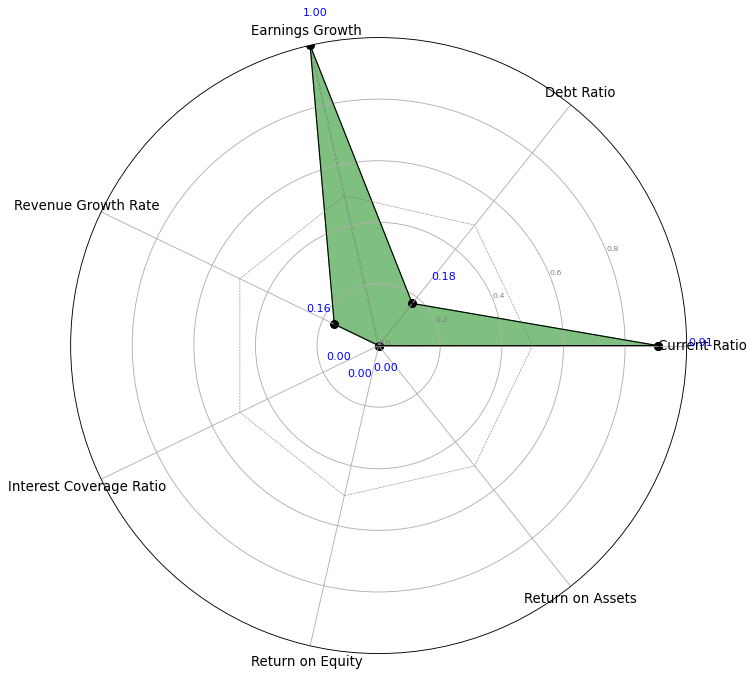

In [268]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=80, subplot_kw=dict(polar=True))

# Define the thresholds
thresholds = [0.7, 0.3, 0.1, 0.1, 0.8, 0.1, 0.1]

# Draw filled polygons
for i in range(num_vars):
    if (metrics[i] == "Current Ratio" and values[i] >= thresholds[i]) or \
       (metrics[i] == "Debt Ratio" and values[i] <= thresholds[i]) or \
       (metrics[i] != "Current Ratio" and metrics[i] != "Debt Ratio" and values[i] >= thresholds[i]):
        color = 'green'
    else:
        color = 'red'
    ax.fill(angles[i:i+2] + angles[i:i+2][::-1],
            values[i:i+2] + [0, 0],
            color=color, alpha=0.5)

# # Draw filled polygons
# for i in range(num_vars):
#     if metrics[i] == "Debt Ratio":
#         color = 'green' if values[i] <= values[i+1] else 'red'
#     else:
#         color = 'green' if values[i] >= values[i+1] else 'red'
#     ax.fill(angles[i:i+2] + angles[i:i+2][::-1],
#             values[i:i+2] + [0, 0],
#             color=color, alpha=0.5)

# Draw outline and points
ax.plot(angles, values, color="black", linewidth=1)
ax.scatter(angles, values, color="black", s=50)

# Draw labels and y-ticks
plt.xticks(angles[:-1], metrics, color='black', size=12)
plt.yticks(np.arange(0, 1, 0.2), color='grey', size=7)
plt.ylim(0, 1)

# Draw y=0.5 line
ax.plot(angles, [0.5] * len(angles), linestyle='dashed', color='grey', linewidth=0.5)

# Annotate values
for angle, value, label in zip(angles, values, metrics):
    if angle > pi:
        alignment = {'horizontalalignment': 'right', 'verticalalignment': 'baseline'}
    else:
        alignment = {'horizontalalignment': 'left', 'verticalalignment': 'baseline'}
    ax.text(angle, value + 0.1, f'{value:.2f}', size=10, color='blue', **alignment)

plt.show()

Explain the color: 

    The color for each metric is to its left. For instance, the Current Ratio color is the one between Debt Ratio and Current Ratio

# Reason For Investment

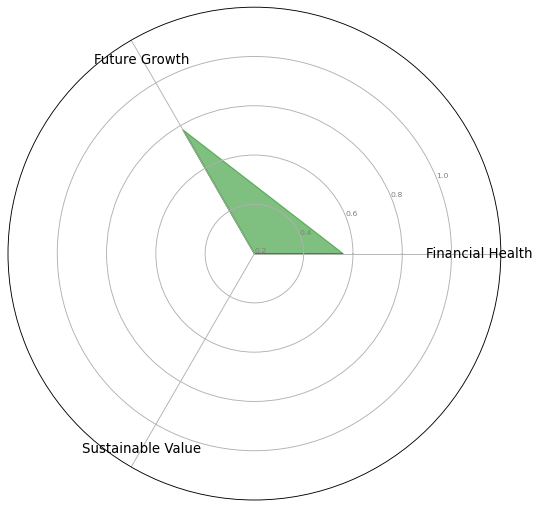

In [269]:
# Get the metrics for each category
financial_health_metrics = ['Debt Ratio', 'Current Ratio', 'Interest Coverage Ratio']
future_growth_metrics = ['Revenue Growth Rate', 'Earnings Growth']
sustainable_value_metrics = ['Return on Equity', 'Return on Assets']

# Calculate the average for each category
financial_health = np.mean([values[metrics.index(metric)] for metric in financial_health_metrics])
future_growth = np.mean([values[metrics.index(metric)] for metric in future_growth_metrics])
sustainable_value = np.mean([values[metrics.index(metric)] for metric in sustainable_value_metrics])

# New metrics and values
new_metrics = ['Financial Health', 'Future Growth', 'Sustainable Value']
new_values = [financial_health, future_growth, sustainable_value]

# Recreate the chart with the new metrics and values
angles = [n / float(len(new_metrics)) * 2 * pi for n in range(len(new_metrics))]
angles += angles[:1]
new_values += new_values[:1]

fig, ax = plt.subplots(figsize=(8, 8), dpi=80, subplot_kw=dict(polar=True))

# Draw filled polygons
for i in range(len(new_metrics)):
#     if new_values[i] >= 0.5: # This is the threshold to determine the color. Modify this according to your use case
#         color = 'green'
#     else:
#         color = 'red'
    ax.fill([angles[i], angles[i + 1], 0], [new_values[i], new_values[i + 1], 0], color='green', alpha=0.5)

# Add padding to xticks labels
xticks = plt.xticks(angles[:-1], new_metrics, color='black', size=12)
for label in xticks[1]:
    label.set_position((label.get_position()[0], label.get_position()[1] + 0.15))

plt.yticks(np.arange(0, 1, 0.2), ['0.2', '0.4', '0.6', '0.8', '1.0'], color='grey', size=7)
plt.ylim(0, 1)
plt.show()

# Todo: Populate values to Google Spreed Sheet